# So Sánh Các Mô Hình - Model Comparison

## Mục Tiêu (OPTIMIZED)
- So sánh **2 thuật toán** trong self-training:
  1. **HistGradientBoostingClassifier** (baseline hiện tại)
  2. **RandomForestClassifier** (ensemble method)
- Xem model nào hưởng lợi nhiều nhất từ self-training
- Phân tích probability calibration và confidence patterns

**⚡ Time Optimization**: Giảm từ 3 → 2 models (saves ~7-8 minutes)
- Bỏ XGBoost (tương tự HGBC, cùng gradient boosting → ít contrast)
- Giữ HGBC vs RandomForest = **Gradient Boosting vs Bagging** → contrast RÕ RÀNG

## Giả Thuyết
- **HGBC**: Tốt cho tabular data, probabilities well-calibrated
- **RandomForest**: Có thể overconfident → cần τ cao hơn, hoặc performance kém

## Setup
- Labeled fraction: 5% (cố định)
- Ngưỡng τ = 0.90 (cố định)
- Max iterations = 10

In [1]:
# PARAMETERS
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

# Fixed parameters
LABELED_FRACTION = 0.05  # Use 5% labeled (95% missing)
TAU = 0.90
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Output directory
RESULTS_DIR = "data/processed/model_comparison_experiments"

In [2]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, AQI_CLASSES,
    time_split, build_feature_columns, _normalize_missing, _align_proba_to_labels
)

# Try importing XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠️ XGBoost not installed. Will skip XGBoost comparison.")

# Setup paths
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

results_dir = (PROJECT_ROOT / RESULTS_DIR).resolve()
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Results directory: {results_dir}")
print(f"XGBoost available: {HAS_XGBOOST}")

⚠️ XGBoost not installed. Will skip XGBoost comparison.
Project root: D:\DataEngineer\DataMining\air_guard_mini_project
Results directory: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments
XGBoost available: False


## Load Dataset

In [3]:
# Load dataset (already has 5% labeled by default)
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

print("Dataset shape:", df.shape)
print("Labeled fraction:", df['is_labeled'].mean())

train_df, test_df = time_split(df, cutoff=CUTOFF)
print(f"\nTrain: {len(train_df):,} samples")
print(f"  - Labeled: {train_df['is_labeled'].sum():,}")
print(f"  - Unlabeled: {(~train_df['is_labeled']).sum():,}")
print(f"Test: {len(test_df):,} samples")

Dataset shape: (420768, 56)
Labeled fraction: 0.08671049129211347



Train: 403,776 samples
  - Labeled: 19,814
  - Unlabeled: 383,962
Test: 16,992 samples


## Define Model Configurations

In [4]:
# Model configurations (OPTIMIZED: 2 models với contrast cao nhất)
model_configs = {
    "HistGradientBoosting": {
        "model_class": HistGradientBoostingClassifier,
        "params": {
            "max_iter": 100,
            "max_depth": 10,
            "learning_rate": 0.1,
            "random_state": RANDOM_STATE
        },
        "color": "steelblue"
    },
    "RandomForest": {
        "model_class": RandomForestClassifier,
        "params": {
            "n_estimators": 100,
            "max_depth": 15,
            "min_samples_split": 10,
            "random_state": RANDOM_STATE,
            "n_jobs": -1
        },
        "color": "forestgreen"
    }
}

# XGBoost bỏ qua để giảm thời gian (~7-8 phút)
# Lý do: XGBoost tương tự HGBC (cùng gradient boosting), ít contrast
# HGBC vs RandomForest = Gradient Boosting vs Bagging → contrast RÕ RÀNG

if HAS_XGBOOST:
    print("⚠️ XGBoost available but SKIPPED for faster execution")
    print("   (XGBoost similar to HGBC, less contrast)\n")

print("Models to compare (optimized - 2 architectures):")
for name in model_configs.keys():
    print(f"  ✓ {name}")

Models to compare (optimized - 2 architectures):
  ✓ HistGradientBoosting
  ✓ RandomForest


## Custom Self-Training Loop for Different Models

In [5]:
def run_self_training_with_model(df, model_name, model_class, model_params, tau=0.90, max_iter=10):
    """Custom self-training implementation to use different models"""
    
    print(f"\n{'='*80}")
    print(f"TRAINING: {model_name} (τ={tau})")
    print(f"{'='*80}")
    
    data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=RANDOM_STATE)
    
    train_df, test_df = time_split(df.copy(), cutoff=CUTOFF)
    feat_cols = build_feature_columns(train_df, data_cfg)
    
    X_all = _normalize_missing(train_df[feat_cols].copy())
    y_all = train_df[data_cfg.target_col].astype("object")
    
    # Split labeled into fit and validation
    labeled_idx = train_df.index[pd.notna(y_all)].to_numpy()
    unlabeled_idx = train_df.index[pd.isna(y_all)].to_numpy()
    
    rng = np.random.default_rng(RANDOM_STATE)
    rng.shuffle(labeled_idx)
    n_val = int(np.floor(VAL_FRAC * labeled_idx.size))
    val_idx = labeled_idx[:n_val]
    fit_idx = labeled_idx[n_val:]
    
    print(f"  Fit set: {len(fit_idx):,}")
    print(f"  Val set: {len(val_idx):,}")
    print(f"  Unlabeled: {len(unlabeled_idx):,}")
    
    # Build pipeline
    cat_cols = [c for c in feat_cols if train_df[c].dtype == "object"]
    num_cols = [c for c in feat_cols if c not in cat_cols]
    
    if cat_cols:
        encoder = ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
        ], remainder="passthrough")
    else:
        encoder = "passthrough"
    
    pipe = Pipeline([
        ("encoder", encoder),
        ("model", model_class(**model_params))
    ])
    
    # Self-training loop
    y_work = y_all.copy()
    history = []
    
    for it in range(1, max_iter + 1):
        # Fit
        pipe.fit(X_all.loc[fit_idx], y_work.loc[fit_idx])
        
        # Validate
        y_val_pred = pipe.predict(X_all.loc[val_idx])
        val_acc = float(accuracy_score(y_all.loc[val_idx], y_val_pred))
        val_f1 = float(f1_score(y_all.loc[val_idx], y_val_pred, average="macro"))
        
        # Pseudo-label
        if unlabeled_idx.size > 0:
            proba_raw = pipe.predict_proba(X_all.loc[unlabeled_idx])
            proba = _align_proba_to_labels(proba_raw, pipe.named_steps["model"].classes_, AQI_CLASSES)
            max_prob = proba.max(axis=1)
            y_hat = np.array(AQI_CLASSES, dtype=object)[proba.argmax(axis=1)]
            
            pick_mask = max_prob >= tau
            picked = unlabeled_idx[pick_mask]
            picked_labels = y_hat[pick_mask]
        else:
            picked = np.array([], dtype=int)
            picked_labels = np.array([], dtype=object)
        
        n_new = int(picked.size)
        history.append({
            "iter": it,
            "val_accuracy": val_acc,
            "val_f1_macro": val_f1,
            "unlabeled_pool": int(unlabeled_idx.size),
            "new_pseudo": n_new,
            "tau": tau
        })
        
        print(f"  Iter {it:2d}: Val F1={val_f1:.4f}, Acc={val_acc:.4f}, New pseudo={n_new:,}, Pool={unlabeled_idx.size:,}")
        
        if n_new < MIN_NEW_PER_ITER:
            print(f"  ⚠️ Stopped early: only {n_new} new pseudo-labels < {MIN_NEW_PER_ITER}")
            break
        
        # Add pseudo-labels
        y_work.loc[picked] = picked_labels
        fit_idx = np.unique(np.concatenate([fit_idx, picked]))
        
        picked_set = set(picked.tolist())
        unlabeled_idx = np.array([i for i in unlabeled_idx if i not in picked_set], dtype=int)
    
    # Final test evaluation
    X_test = _normalize_missing(test_df[feat_cols].copy())
    y_test = test_df[data_cfg.target_col].astype("object")
    mask = pd.notna(y_test)
    
    y_pred = pipe.predict(X_test.loc[mask])
    
    test_acc = float(accuracy_score(y_test.loc[mask], y_pred))
    test_f1 = float(f1_score(y_test.loc[mask], y_pred, average="macro"))
    report = classification_report(y_test.loc[mask], y_pred, output_dict=True)
    
    print(f"\n  ✅ Test Results:")
    print(f"     Accuracy: {test_acc:.4f}")
    print(f"     F1-macro: {test_f1:.4f}")
    
    return {
        "model_name": model_name,
        "history": history,
        "test_accuracy": test_acc,
        "test_f1_macro": test_f1,
        "per_class_report": report,
        "total_pseudo_labels": sum([h["new_pseudo"] for h in history]),
        "iterations_completed": len(history)
    }

## Run Experiments for All Models

In [6]:
results = {}

for model_name, config in model_configs.items():
    result = run_self_training_with_model(
        df=df,
        model_name=model_name,
        model_class=config["model_class"],
        model_params=config["params"],
        tau=TAU,
        max_iter=MAX_ITER
    )
    
    results[model_name] = result

print(f"\n{'='*80}")
print("ALL MODEL EXPERIMENTS COMPLETED")
print(f"{'='*80}")


TRAINING: HistGradientBoosting (τ=0.9)


  Fit set: 15,852
  Val set: 3,962
  Unlabeled: 383,962


  Iter  1: Val F1=0.6673, Acc=0.7092, New pseudo=72,143, Pool=383,962


  Iter  2: Val F1=0.6584, Acc=0.6969, New pseudo=194,785, Pool=311,819


  Iter  3: Val F1=0.6099, Acc=0.6504, New pseudo=41,417, Pool=117,034


  Iter  4: Val F1=0.6066, Acc=0.6482, New pseudo=19,565, Pool=75,617


  Iter  5: Val F1=0.5814, Acc=0.6383, New pseudo=7,232, Pool=56,052


  Iter  6: Val F1=0.5925, Acc=0.6439, New pseudo=5,119, Pool=48,820


  Iter  7: Val F1=0.5874, Acc=0.6323, New pseudo=2,188, Pool=43,701


  Iter  8: Val F1=0.5800, Acc=0.6328, New pseudo=1,642, Pool=41,513


  Iter  9: Val F1=0.5767, Acc=0.6343, New pseudo=1,003, Pool=39,871


  Iter 10: Val F1=0.5795, Acc=0.6338, New pseudo=830, Pool=38,868



  ✅ Test Results:
     Accuracy: 0.5682
     F1-macro: 0.4919

TRAINING: RandomForest (τ=0.9)


  Fit set: 15,852
  Val set: 3,962
  Unlabeled: 383,962


  Iter  1: Val F1=0.5653, Acc=0.6699, New pseudo=1,031, Pool=383,962


  Iter  2: Val F1=0.5619, Acc=0.6689, New pseudo=5,745, Pool=382,931


  Iter  3: Val F1=0.5552, Acc=0.6663, New pseudo=22,652, Pool=377,186


  Iter  4: Val F1=0.5273, Acc=0.6570, New pseudo=34,999, Pool=354,534


  Iter  5: Val F1=0.4928, Acc=0.6557, New pseudo=23,998, Pool=319,535


  Iter  6: Val F1=0.4747, Acc=0.6487, New pseudo=22,423, Pool=295,537


  Iter  7: Val F1=0.4734, Acc=0.6461, New pseudo=21,660, Pool=273,114


  Iter  8: Val F1=0.4690, Acc=0.6426, New pseudo=17,223, Pool=251,454


  Iter  9: Val F1=0.4597, Acc=0.6358, New pseudo=15,524, Pool=234,231


  Iter 10: Val F1=0.4461, Acc=0.6287, New pseudo=15,108, Pool=218,707



  ✅ Test Results:
     Accuracy: 0.5628
     F1-macro: 0.4130

ALL MODEL EXPERIMENTS COMPLETED


## Save Results

In [7]:
# Save detailed results
output_file = results_dir / "model_comparison_results.json"
with open(output_file, "w") as f:
    json.dump(results, f, indent=2)

print(f"✅ Saved results to: {output_file}")

✅ Saved results to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\model_comparison_results.json


## Create Summary Table

In [8]:
summary_data = []
for model_name, res in results.items():
    summary_data.append({
        "Model": model_name,
        "Test Accuracy": res["test_accuracy"],
        "Test F1-macro": res["test_f1_macro"],
        "Pseudo-labels": res["total_pseudo_labels"],
        "Iterations": res["iterations_completed"],
        "Val F1 Peak": max([h["val_f1_macro"] for h in res["history"]])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values("Test F1-macro", ascending=False)

print("\n📊 SUMMARY TABLE:")
print("="*100)
display(summary_df)

# Save summary
summary_csv = results_dir / "model_comparison_summary.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"\n✅ Saved summary to: {summary_csv}")


📊 SUMMARY TABLE:


,Model,Test Accuracy,Test F1-macro,Pseudo-labels,Iterations,Val F1 Peak
0,HistGradientBoosting,0.568232,0.49193,345924,10,0.667327
1,RandomForest,0.562774,0.41304,180363,10,0.565281



✅ Saved summary to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\model_comparison_summary.csv


## Visualization 1: Test Performance Comparison

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\test_performance_by_model.png


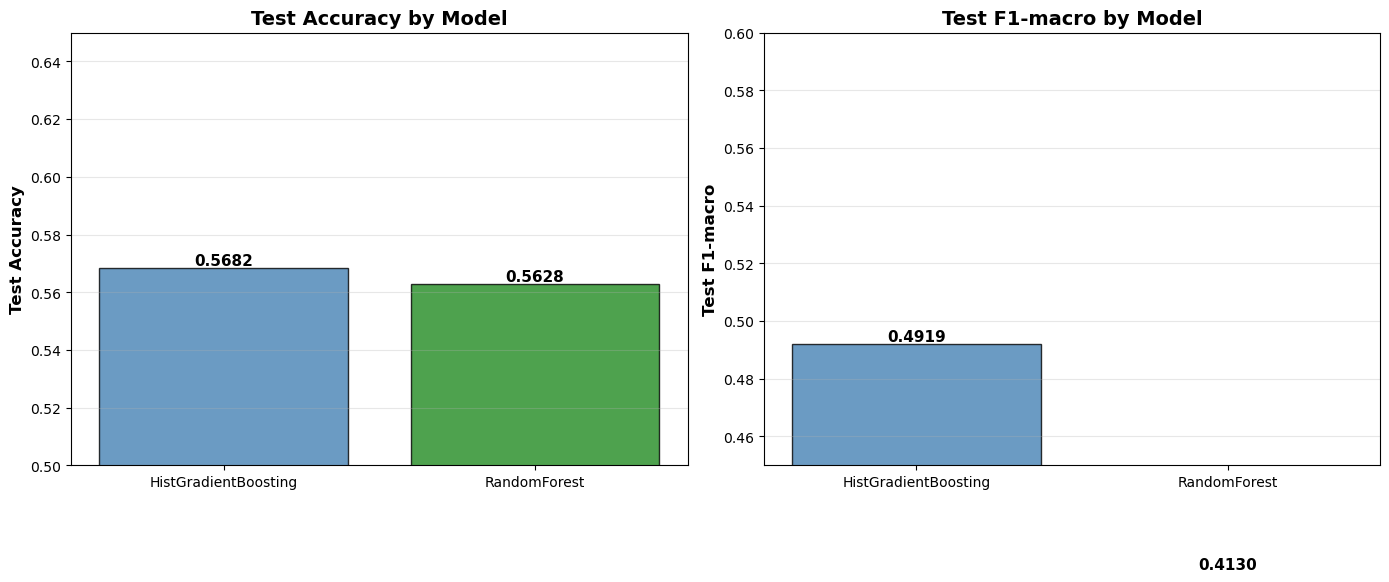

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = summary_df["Model"].tolist()
accuracies = summary_df["Test Accuracy"].tolist()
f1_scores = summary_df["Test F1-macro"].tolist()
colors = [model_configs[m]["color"] for m in models]

# Accuracy
ax1 = axes[0]
bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel("Test Accuracy", fontsize=12, fontweight='bold')
ax1.set_title("Test Accuracy by Model", fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.50, 0.65])

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# F1-macro
ax2 = axes[1]
bars2 = ax2.bar(models, f1_scores, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel("Test F1-macro", fontsize=12, fontweight='bold')
ax2.set_title("Test F1-macro by Model", fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0.45, 0.60])

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "test_performance_by_model.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 2: Learning Curves

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\learning_curves_by_model.png


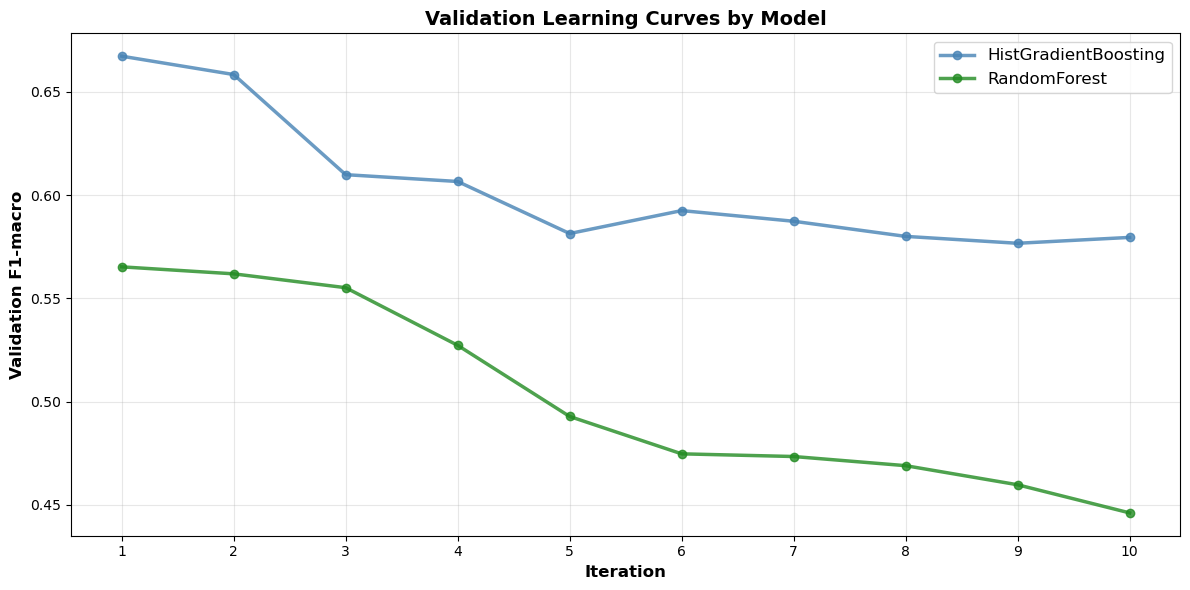

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

for model_name, res in results.items():
    history = res["history"]
    iterations = [h["iter"] for h in history]
    val_f1 = [h["val_f1_macro"] for h in history]
    color = model_configs[model_name]["color"]
    
    ax.plot(iterations, val_f1, marker='o', linewidth=2.5, 
            label=model_name, color=color, alpha=0.8)

ax.set_xlabel("Iteration", fontsize=12, fontweight='bold')
ax.set_ylabel("Validation F1-macro", fontsize=12, fontweight='bold')
ax.set_title("Validation Learning Curves by Model", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='best')
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 11))

plt.tight_layout()
plot_file = results_dir / "learning_curves_by_model.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 3: Pseudo-labeling Activity

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\pseudo_labeling_by_model.png


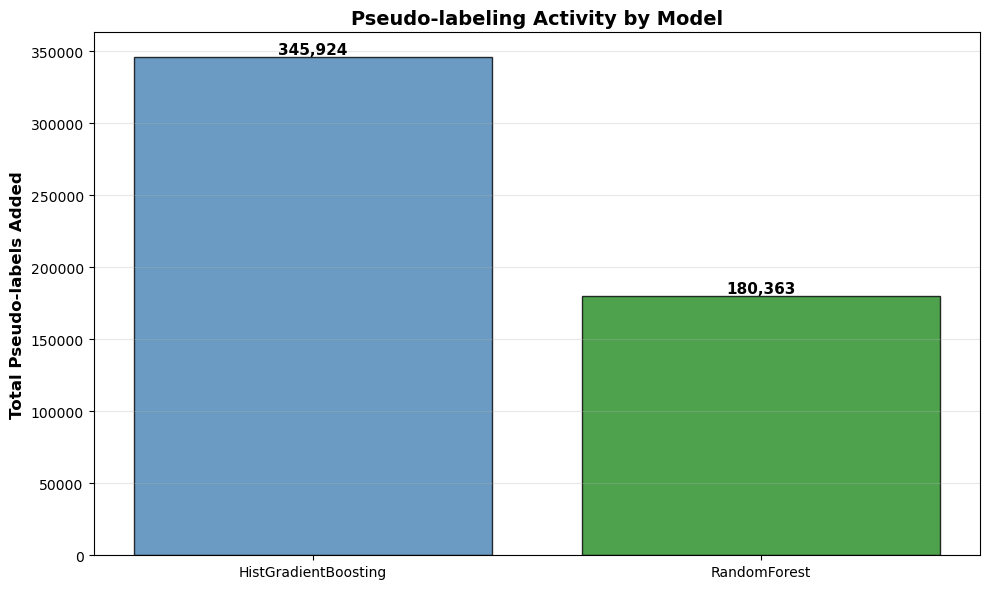

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

models = summary_df["Model"].tolist()
pseudo_counts = summary_df["Pseudo-labels"].tolist()
colors_list = [model_configs[m]["color"] for m in models]

bars = ax.bar(models, pseudo_counts, color=colors_list, alpha=0.8, edgecolor='black')
ax.set_ylabel("Total Pseudo-labels Added", fontsize=12, fontweight='bold')
ax.set_title("Pseudo-labeling Activity by Model", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "pseudo_labeling_by_model.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Visualization 4: Per-Class F1 Heatmap

✅ Saved plot: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\per_class_f1_heatmap.png


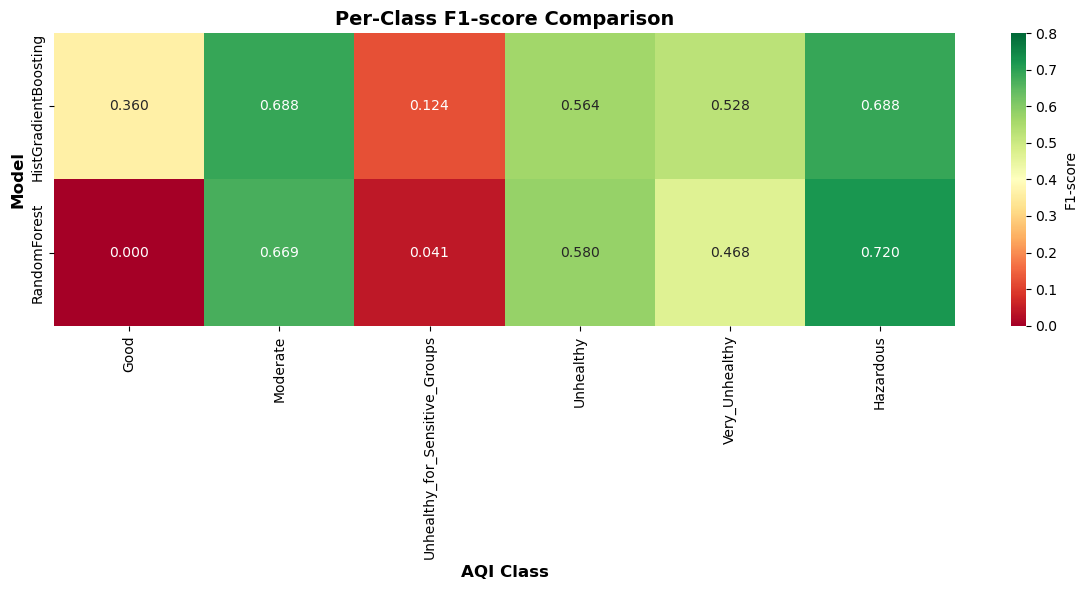

In [12]:
# Extract per-class F1 scores
per_class_data = []
for model_name, res in results.items():
    row = {"Model": model_name}
    for aqi_class in AQI_CLASSES:
        if aqi_class in res["per_class_report"]:
            row[aqi_class] = res["per_class_report"][aqi_class]["f1-score"]
    per_class_data.append(row)

per_class_df = pd.DataFrame(per_class_data)
per_class_df = per_class_df.set_index("Model")

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(per_class_df, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=0.8, ax=ax, cbar_kws={'label': 'F1-score'})
ax.set_title("Per-Class F1-score Comparison", fontsize=14, fontweight='bold')
ax.set_xlabel("AQI Class", fontsize=12, fontweight='bold')
ax.set_ylabel("Model", fontsize=12, fontweight='bold')

plt.tight_layout()
plot_file = results_dir / "per_class_f1_heatmap.png"
plt.savefig(plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved plot: {plot_file}")
plt.show()

## Analysis & Insights

In [13]:
print("\n" + "="*100)
print("📊 KEY FINDINGS")
print("="*100)

best_idx = summary_df["Test F1-macro"].idxmax()
best_model = summary_df.loc[best_idx]

print(f"\n🏆 Best Model: {best_model['Model']}")
print(f"   Test F1-macro: {best_model['Test F1-macro']:.4f}")
print(f"   Test Accuracy: {best_model['Test Accuracy']:.4f}")
print(f"   Pseudo-labels: {best_model['Pseudo-labels']:,}")
print(f"   Val F1 Peak: {best_model['Val F1 Peak']:.4f}")

print(f"\n📈 Ranking by F1-macro:")
for i, row in summary_df.iterrows():
    print(f"   {i+1}. {row['Model']}: {row['Test F1-macro']:.4f}")

print(f"\n💡 Model Behaviors:")
for model_name, res in results.items():
    peak_iter = max(res["history"], key=lambda x: x["val_f1_macro"])
    print(f"   {model_name}:")
    print(f"      - Peak val F1: {peak_iter['val_f1_macro']:.4f} (iter {peak_iter['iter']})")
    print(f"      - Pseudo-labels/iter: {res['total_pseudo_labels'] / res['iterations_completed']:.0f} avg")

print(f"\n✅ All visualizations saved to: {results_dir}")
print("="*100)


📊 KEY FINDINGS

🏆 Best Model: HistGradientBoosting
   Test F1-macro: 0.4919
   Test Accuracy: 0.5682
   Pseudo-labels: 345,924
   Val F1 Peak: 0.6673

📈 Ranking by F1-macro:
   1. HistGradientBoosting: 0.4919
   2. RandomForest: 0.4130

💡 Model Behaviors:
   HistGradientBoosting:
      - Peak val F1: 0.6673 (iter 1)
      - Pseudo-labels/iter: 34592 avg
   RandomForest:
      - Peak val F1: 0.5653 (iter 1)
      - Pseudo-labels/iter: 18036 avg

✅ All visualizations saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments


## Dashboard Summary

In [14]:
dashboard_data = {
    "experiment_type": "model_comparison",
    "parameters": {
        "tau": TAU,
        "max_iter": MAX_ITER,
        "labeled_fraction": LABELED_FRACTION,
        "models": list(model_configs.keys())
    },
    "summary": summary_df.to_dict(orient='records'),
    "best_model": {
        "name": best_model["Model"],
        "f1_macro": float(best_model["Test F1-macro"]),
        "accuracy": float(best_model["Test Accuracy"])
    },
    "visualizations": [
        "test_performance_by_model.png",
        "learning_curves_by_model.png",
        "pseudo_labeling_by_model.png",
        "per_class_f1_heatmap.png"
    ]
}

dashboard_file = results_dir / "dashboard_summary.json"
with open(dashboard_file, "w") as f:
    json.dump(dashboard_data, f, indent=2)

print(f"✅ Dashboard summary saved to: {dashboard_file}")
display(Markdown(f"## Experiment Complete! ✅\n\nResults: `{results_dir}`"))

✅ Dashboard summary saved to: D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments\dashboard_summary.json


## Experiment Complete! ✅

Results: `D:\DataEngineer\DataMining\air_guard_mini_project\data\processed\model_comparison_experiments`